In [53]:
"""
This is a Python notebook to investigate the performance of Synaptic Intelligence (https://arxiv.org/pdf/1703.04200.pdf)
to improve catastrophic forgetting in multi-task learning on two simple tasks.

There are two tasks we train on:

1.) MNIST
2.) Fashion MNIST

We essentially run two experiments in this notebook both using the same basic model (simple four layer model - 1 conv
layer followed by 3 linear layers)

a.) Train first on MNIST, then on Fashion MNIST. Evaluate performance on MNIST and observe catastrophic forgetting
b.) Train first on MNIST, then on Fashion MNIST but use the Synaptic Intelligence strategy. Evaluate performance
on MNIST and observe that catastrophic forgetting is reduced.
"""

# basic imports
import numpy as np
import json
import random
import itertools
import pandas as pd
import copy


from tqdm.auto import tqdm, trange
from collections import defaultdict


import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from contlearn.getdata import getMNIST, getFashionMNIST

# setup basic size and datasets
batch_size = 128

# task A training and test set
train_loader_mnist, test_loader_mnist = getMNIST(batch_size=batch_size)

# task B training and test set
train_loader_fashion, test_loader_fashion = getFashionMNIST(batch_size=batch_size)

tensor(8)
torch.Size([28, 28])


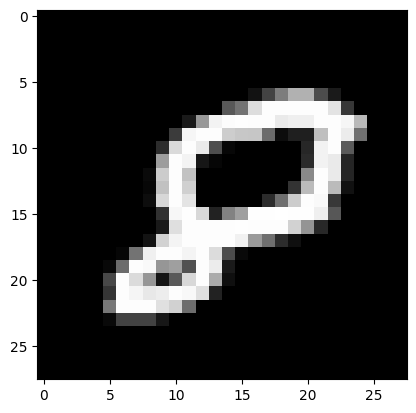

In [5]:
# Plot example of image from the basic MNIST dataset

input_image, target_label = next(iter(train_loader_mnist))

print(target_label[0])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)

Trouser
torch.Size([28, 28])


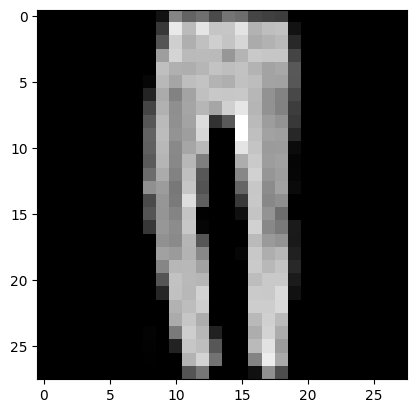

In [55]:
# Plot example from the fashion MNIST dataset

input_image, target_label = next(iter(train_loader_fashion))

fashion_key = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

print(fashion_key[int(target_label[0].detach().cpu().numpy())])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)

In [56]:
# figure out if the user has a GPU or not

from contlearn.getmodels import MLP,BasicCNN
from contlearn.gettrainer import test, var2device

print('you are using PyTorch version ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print("you have", torch.cuda.device_count(), "GPUs")
    device = torch.device("cuda:0")
    print(device)
else:
    use_cuda = False
    print('no GPUs detected')
    device = torch.device("cpu")

you are using PyTorch version  1.12.0+cu113
you have 1 GPUs
cuda:0


In [57]:
# test that a model can be initialized and sanity check the shapes

model = BasicCNN(fmap_size=128)

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# push an image through it
input_image, target_label = next(iter(train_loader_fashion))
print("Original shape: {}".format(input_image.shape))
input_image = var2device(input_image)
print(input_image.shape)
output = model(input_image)
print(output.shape)

Original shape: torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])


In [66]:
"""
Train for one epoch given the input data loader and optimizer
"""
def one_epoch_baseline(model: nn.Module, data_loader: torch.utils.data.DataLoader, optimizer):
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        # no need for the channel dim
        # bs,1,h,w -> bs,h,w
        #input = input.squeeze(1) 
        input, target = var2device(input), var2device(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

"""
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder (this is useful to evaluate performance of MNIST when training on FASHION_MNIST, for example)
"""
def baseline_training(
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True,
    lr = 1e-3
):
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_baseline(model,train_loader, optimizer)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        acc2 = None
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
        
        print("Epoch: {}, epoch_loss: {}, val_acc: {} val2_acc: {}".format(epoch, epoch_loss, acc, val2_acc))
            
    return train_loss, val_acc, val2_acc, model 

In [62]:
# Basic method to plot test accuracy on the mnist (and optionally fashion mnist) dataset
def plot_validation_accs(mnist_val_accs, fashion_mnist_val_accs = None):
    epochs = range(0, len(mnist_val_accs))
    plt.plot(epochs, mnist_val_accs, label = 'mnist_validation_set')
    if fashion_mnist_val_accs is not None:
        plt.plot(epochs, fashion_mnist_val_accs, label = 'fashion_mnist_validation_set')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [59]:
"""
Experiment A: Train on MNIST, and then fashion MNIST
"""
learning_rate = 1e-3

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc,  model = baseline_training(
    model,
    epochs = 10,
    train_loader = train_loader_mnist,
    test_loader = test_loader_mnist,
    lr = learning_rate
)

  0%|          | 0/10 [00:01<?, ?it/s]

Epoch: 0, epoch_loss: 0.2638451199668811, val_acc: 0.9672999978065491 val2_acc: None
Epoch: 1, epoch_loss: 0.0745071353815766, val_acc: 0.9786999821662903 val2_acc: None
Epoch: 2, epoch_loss: 0.044331399988986726, val_acc: 0.981499969959259 val2_acc: None
Epoch: 3, epoch_loss: 0.028924557302437072, val_acc: 0.9858999848365784 val2_acc: None
Epoch: 4, epoch_loss: 0.019608880582350944, val_acc: 0.9840999841690063 val2_acc: None
Epoch: 5, epoch_loss: 0.01378172191481954, val_acc: 0.9842999577522278 val2_acc: None
Epoch: 6, epoch_loss: 0.009662266446104737, val_acc: 0.9818999767303467 val2_acc: None
Epoch: 7, epoch_loss: 0.009683305512540223, val_acc: 0.9840999841690063 val2_acc: None
Epoch: 8, epoch_loss: 0.007708760593751711, val_acc: 0.9828999638557434 val2_acc: None
Epoch: 9, epoch_loss: 0.006298609856527727, val_acc: 0.9835000038146973 val2_acc: None


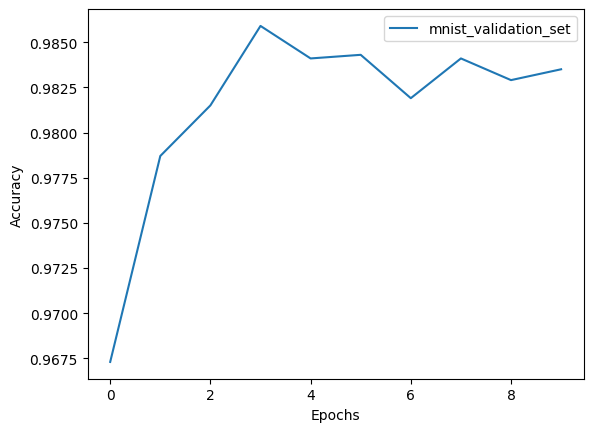

In [63]:
# Verify that we can solve MNIST pretty handily

plot_validation_accs(val_acc)

In [67]:
# now, train the same model on fashion MNIST (after training on MNIST)

train_loss, val_acc, val2_acc,  model = baseline_training(
    model,
    epochs = 10,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
    lr = learning_rate
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, epoch_loss: 0.2623609897297329, val_acc: 0.8894999623298645 val2_acc: [array(0.4603, dtype=float32)]
Epoch: 1, epoch_loss: 0.19298598246533732, val_acc: 0.9014999866485596 val2_acc: [array(0.4603, dtype=float32), array(0.4877, dtype=float32)]
Epoch: 2, epoch_loss: 0.15001005770714043, val_acc: 0.9038999676704407 val2_acc: [array(0.4603, dtype=float32), array(0.4877, dtype=float32), array(0.4278, dtype=float32)]
Epoch: 3, epoch_loss: 0.11563710030764024, val_acc: 0.9054999947547913 val2_acc: [array(0.4603, dtype=float32), array(0.4877, dtype=float32), array(0.4278, dtype=float32), array(0.4283, dtype=float32)]
Epoch: 4, epoch_loss: 0.09035650782112374, val_acc: 0.9097999930381775 val2_acc: [array(0.4603, dtype=float32), array(0.4877, dtype=float32), array(0.4278, dtype=float32), array(0.4283, dtype=float32), array(0.3972, dtype=float32)]
Epoch: 5, epoch_loss: 0.07049754153547892, val_acc: 0.9041000008583069 val2_acc: [array(0.4603, dtype=float32), array(0.4877, dtype=float32),

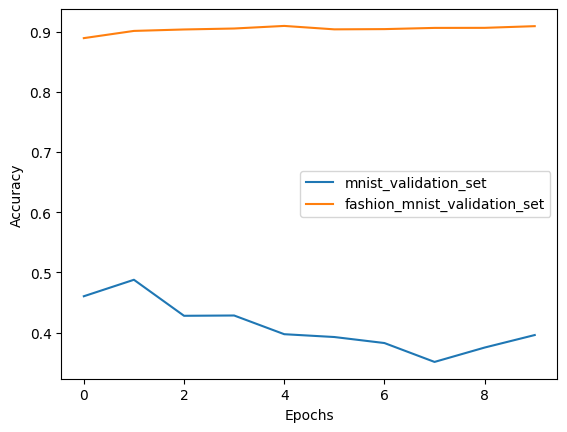

In [76]:
# Now plot performance on basic MNIST after training on fashion MNIST, and observe clear catastrophic forgetting

plot_validation_accs(val2_acc, val_acc)

In [69]:

"""
This class encapulates the training of a pytorch model in a multi-task setting when using Synaptic Intelligence.

The main way to use this class is to:

1.) Call train(...) to train on a task and record variables needed for SI (product of gradient and how far each param moved)
2.) Call finish_task(...) to compute importance weights required for SI
3.) Call init_new_task(...) to setup a new task to train on


These are a few improvements and cavaets to note:

1.) The loss function for the model is hardcoded within the "train" method for this particular toy problem. Ideally,
we can pass in a generic method to compute the loss given the dataset

2.) Due to way pytorch optimizers work, there's no way to get "how much" a parameter "would" be updated by without
actually running the optimizer. This means that we actually have to do backprop twice for the normal part of the loss
and then for the "regularization" part of the loss instead of computing the loss together and doing one backprop step.
This makes things slightly inefficient and not exactly as presented in the paper, but unless we are using an optimizer
with a "known" way of how much each parameter gets updated (like SGD), then I don't see a way around this.

"""
class SITrainer:
    
    
    def init_new_task(self, task_name, debug=False):        
        # reset small omega dict
        self.param_importance_current_task = dict()
        for n, p in self.model.named_parameters():
            self.param_importance_current_task[n] = torch.zeros(p.shape)
            if not debug:
                self.param_importance_current_task[n] = var2device(self.param_importance_current_task[n])
            
        
        # update task name and make sure "finish_task" was called first by checking if current_task was None?
        assert self.current_task == None
        self.current_task = task_name
        
    
    # calculate the big omegas the params with the current task and save the final snapshot of params for this task
    # if "validate_importance_vals = True" then check that all the importance parameters for this task were >= 0
    def finish_task(self, debug = False, validate_importance_vals = True):
        
        # make sure finish_task is not called twice in a row
        assert self.current_task != None
        
        # stores map from var_name --> big omega (importance)
        self.prev_tasks_to_final_importance_params[self.current_task] = dict()
        
        # store snapshot of the final weights learned when training on this task
        snapshot_of_task_weights = dict()
        
        
        # save all the params at the end of training this task 
        for n, p in self.model.named_parameters():
            
            current_param_value = p.clone().detach()
            delta_from_prev_task = current_param_value
            
            # if we aren't the first task, then need to subtract from where we stopped in the last task to get how far we are
            if self.snapshot_of_prev_task_weights != None:
                delta_from_prev_task = current_param_value - self.snapshot_of_prev_task_weights[n]
            
            denominator = delta_from_prev_task ** 2 + self.epsilon
            numerator = self.param_importance_current_task[n]
            
            if validate_importance_vals:
                print("doing validation for param {}...".format(n))
                assert torch.all(numerator >= 0)
            
            omega_val = torch.div(numerator, denominator)
            
            if debug:
                print("Processing omega for param: {}, shape is: {}".format(n, omega_val.shape))
            
            # record omega value for this task
            self.prev_tasks_to_final_importance_params[self.current_task][n] = omega_val
            
            # record the new snapshot value, as this is now the latest task
            snapshot_of_task_weights[n] = current_param_value
        
        # add to current task to list of tasks that were completed
        self.tasks.append(self.current_task)
        
        # update the current last set of weights and set current_task to None
        self.snapshot_of_prev_task_weights = snapshot_of_task_weights
        self.current_task = None
        

    
    def __init__(self, model, optim, initial_task, lambda_weight = 1.0, debug = False):
        self.model = model
        self.optim = optim
        
        self.tasks = []
        self.current_task = None
        self.param_importance_current_task = dict()
        
        # dictionary from task name, which holds a dictionary from param_name --> big omega value
        self.prev_tasks_to_final_importance_params = dict()
        
        # snapshot of weights from the last task completed
        self.snapshot_of_prev_task_weights = None
        
        self.init_new_task(initial_task, debug = debug)
        
        # for blending importance weights
        self.regularization_lambda = lambda_weight
        
        # for normalization term in the denominator
        self.epsilon = 1e-3
        
    
    # shape: same as the shape of param (we're just accumulating it)
    def get_importance_all_prev_tasks(self, param_name, debug = False):
        
        if debug:
            print("Trying to process importance for all past tasks: {}".format(self.tasks))
        
        total_importance_all_prev_tasks = 0
    
        for prev_task_name in self.tasks:
            if debug:
                print("Shape of importance var for param {} and task: {}, is: {}".format(param_name, prev_task_name, self.prev_tasks_to_final_importance_params[prev_task_name][param_name].shape))
            total_importance_all_prev_tasks += self.prev_tasks_to_final_importance_params[prev_task_name][param_name]
            
        return total_importance_all_prev_tasks
    
    
    # note: all importance values should be > 0 if you do enough training steps
    def inspect_importance_values_previous_tasks(self, param_name, debug = True):
        
        if debug:
            print("Trying to process importance for all past tasks: {}".format(self.tasks))
        
        total_importance_all_prev_tasks = 0
    
        for prev_task_name in self.tasks:
            
            importance_prev_task = self.prev_tasks_to_final_importance_params[prev_task_name][param_name]
            total_importance = torch.sum(importance_prev_task)
            avg_importance = torch.mean(importance_prev_task)
            min_value = torch.min(importance_prev_task)
            
            if debug:
                print("Shape of importance var for param {} and task: {}, is: {}, total sum is: {}, avg: {}, min: {}".format(param_name, prev_task_name, self.prev_tasks_to_final_importance_params[prev_task_name][param_name].shape, total_importance, avg_importance, min_value))
            total_importance_all_prev_tasks += importance_prev_task
            
        return total_importance_all_prev_tasks
    
    
    def train(self, epochs, train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader
              , alternative_test_loader: torch.utils.data.DataLoader = None, debug = False):
        
        train_loss_unreg, train_loss_reg, val_acc, val2_acc = [], [], [], []

        for epoch in tqdm(range(epochs)):

            epoch_loss_unreg, epoch_loss_reg = self.one_epoch_update(train_loader, debug = debug)
            train_loss_unreg.append(epoch_loss_unreg)
            train_loss_reg.append(epoch_loss_reg)

            acc = test(self.model,test_loader)
            val_acc.append(acc.item()) #detach().cpu().numpy())
            print("Completed epoch {}, latest val accuracy is: {}, epoch loss unreg: {}, epoch loss reg: {}".format(epoch, acc.item(), epoch_loss_unreg, epoch_loss_reg))

            if alternative_test_loader is not None:
                acc2 = test(self.model,alternative_test_loader)
                val2_acc.append(acc2.item()) #.detach().cpu().numpy())
                print("Completed epoch {}, latest alternative val accuracy is: {}".format(epoch, acc2.item()))

        return train_loss_unreg, train_loss_reg, val_acc, val2_acc      
    
    # todo (Moose): could probably be simplified if we just assume there's a way to map from gradient 
    # to how much each "param" will move (ie. SGD)
    # todo (Moose): maybe allow user to specify to just train on X number of batches
    def one_epoch_update(self,  data_loader: torch.utils.data.DataLoader, debug = False):     
        
        # make sure a valid task has been assigned
        assert self.current_task != None
        
        param_to_gradients_for_current_task = dict()
        unreg_epoch_loss = 0
        regularlization_epoch_loss = 0
        
        for input, target in data_loader:
            
            # 1.Save current parameters and current offsets from the previous task snapshot
            
            old_params = {}
            
            # delta is difference between current param and final params at the end of the last task.
            delta_from_prev_task_snapshot = {}
            for n, p in self.model.named_parameters():
                old_params[n] = p.clone().detach()
                if self.snapshot_of_prev_task_weights != None:
                    delta_from_prev_task_snapshot[n] = old_params[n] - self.snapshot_of_prev_task_weights[n]

            
            # 2. Collect the gradients without regularization term, just use normal XEntropy loss 

            # keep things on CPU for better debugging if requested
            if not debug:
                input, target = var2device(input), var2device(target)
            
            # zero out the optimizer first 
            self.optim.zero_grad()
            
            output = self.model(input)
            loss = F.cross_entropy(output, target)
        
            #  We need retain graph here, see https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
            loss.backward(retain_graph=True) 
            
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    param_to_gradients_for_current_task[n] = p.grad.clone().detach() # do we need to clone this ? Yes, because we are doing the zero_grad thing here?
                if debug:
                    print("Shape of grad tensor in original grad calculation is: {}".format(p.grad.shape))

            # 3. Normal update with regularization (once we've recorded the gradients)
            # todo (Moose): replace this with a generic way to get the usual loss function for a task 
            loss = F.cross_entropy(output, target)
            self.optim.zero_grad()
            loss.backward() # don't need retain-graph here because we are really doing backprop twice ?
            self.optim.step()

            # 4. Accumulate the small w for this task 
            for n, p in self.model.named_parameters():
                delta = p.detach() - old_params[n]
                if n in param_to_gradients_for_current_task.keys():  # In multi-head network, some head could have no grad (lazy) since no loss go through it.
                    self.param_importance_current_task[n] -= param_to_gradients_for_current_task[n] * delta  # w[n] is >=0 (todo - Moose - is this always true? random guy says it in his code)
                else:
                    print("WARNING!!! no grad found for variable: {}",format(p))
                    
            # acumulate the total loss (before the regularization term)
            unreg_epoch_loss += loss.item()
            
            if debug:
                print("==== finished getting the omegas ====")
            
            
            # 5. NOW: incorperate the loss term for the regularization portion if we had some previous tasks
            # this is a bit tricky since we want to get the value "before" the first part of the gradient update ?
            if self.snapshot_of_prev_task_weights != None:
                
                
                if debug:
                    print("==== starting SI stuff ====")
                
                # zero the grads again before the second update (based on regularization)
                self.optim.zero_grad()
                
                total_reg_loss = 0
                
                # compute regularization loss for each param
                for n, p in self.model.named_parameters():
                    
                    if debug:
                        print("==== processing SI For param: {} ====".format(n))
                        
                    # shape: same as param
                    param_total_importance_all_past_tasks = self.get_importance_all_prev_tasks(n, debug = debug)
                    
                    # shape: same as param
                    # need to use the current param_value MINUS the value at the end of the last task update (a constant)
                    # at this point in the code, we always have >= 2 tasks, so no need to use zeros in case for the prev task
                    param_delta_from_last_task_sq = (p - self.snapshot_of_prev_task_weights[n])**2
                    
                    if debug:
                        print("=====Shape of total param importance: {}, shape of param delta: {}".format(param_total_importance_all_past_tasks.shape, param_delta_from_last_task_sq.shape))
                        
                    
                    # element-wise multiplication between omega values and the real param
                    # then take the sum since obviously have multiple weights per param, and we need to get back to a scalar
                    reg_loss_for_param = torch.mul(param_total_importance_all_past_tasks, param_delta_from_last_task_sq)
                    

                    # one param in the pytorch world probably has multiple individual weights, we want to just sum over all of them
                    # since the loss is a single scalar
                    final_reg_loss_for_param = torch.sum(reg_loss_for_param)

                    if debug:
                        print("Param total importance for all past tasks is: {}, param delta sum is: {}".format(torch.sum(param_total_importance_all_past_tasks), torch.sum(param_delta_from_last_task_sq)))
                        print("reg loss for this param is: {}, final reg loss is: {}".format(reg_loss_for_param.shape, final_reg_loss_for_param))                   
                    
                    total_reg_loss += final_reg_loss_for_param
                
                
                scaled_reg_loss = self.regularization_lambda * total_reg_loss
                regularlization_epoch_loss += scaled_reg_loss
                
                if debug:
                    print("====Total reg loss: {}, scaled reg loss: {}, Scaled reg loss has shape: {}".format(total_reg_loss, scaled_reg_loss, scaled_reg_loss.shape))
                
                scaled_reg_loss.backward()
                self.optim.step() # update based on the regularization loss
            
            
            if debug:
                # maybe print the average value in each param
                for k,v in self.param_importance_current_task.items():
                    print("param: {}, average small omega: {}".format(k, torch.mean(v)))
                print("Task is: {}".format(self.current_task))
                print("Breaking out of loop...")
                break
        
        return unreg_epoch_loss / len(data_loader), regularlization_epoch_loss / len(data_loader)

In [70]:
"""
Experiment B - Train on MNIST and then Fashion MNIST using the SI Trainer
"""


new_model_v3 = BasicCNN(fmap_size=128)
should_debug=False
n_epochs = 10

if torch.cuda.is_available() and use_cuda and not should_debug:
    new_model_v3.cuda()

optimizer = optim.Adam(params=new_model_v3.parameters(), lr=1e-3)

trainer = SITrainer(new_model_v3, optimizer, initial_task = 'test_task', lambda_weight = 0.15, debug=should_debug)
mnist_reg_losses, mnist_unreg_losses, mnist_val_accs, mnist_alternative_val_accs = trainer.train(epochs = n_epochs, train_loader= train_loader_mnist, test_loader = test_loader_mnist)

  0%|          | 0/10 [00:02<?, ?it/s]

Completed epoch 0, latest val accuracy is: 0.9711999893188477, epoch loss unreg: 0.29219775130626746, epoch loss reg: 0.0
Completed epoch 1, latest val accuracy is: 0.9810999631881714, epoch loss unreg: 0.07884514131652776, epoch loss reg: 0.0
Completed epoch 2, latest val accuracy is: 0.9836999773979187, epoch loss unreg: 0.04950666773134966, epoch loss reg: 0.0
Completed epoch 3, latest val accuracy is: 0.982699990272522, epoch loss unreg: 0.03162501087295078, epoch loss reg: 0.0
Completed epoch 4, latest val accuracy is: 0.9822999835014343, epoch loss unreg: 0.02362085952322239, epoch loss reg: 0.0
Completed epoch 5, latest val accuracy is: 0.9822999835014343, epoch loss unreg: 0.01638307229644045, epoch loss reg: 0.0
Completed epoch 6, latest val accuracy is: 0.9860999584197998, epoch loss unreg: 0.011950988631437608, epoch loss reg: 0.0
Completed epoch 7, latest val accuracy is: 0.9824999570846558, epoch loss unreg: 0.010273198698934512, epoch loss reg: 0.0
Completed epoch 8, late

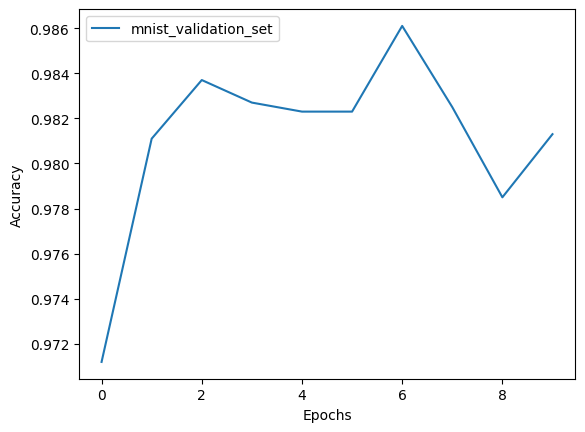

In [71]:
# plot test accuracy on mnist validation, just to sanity check 

plot_validation_accs(mnist_val_accs)

In [72]:
# finsih the mnist task and start a new one
trainer.finish_task()
trainer.init_new_task("fashion_mnist")

doing validation for param conv1.weight...
doing validation for param conv1.bias...
doing validation for param fc1.weight...
doing validation for param fc1.bias...
doing validation for param fc2.weight...
doing validation for param fc2.bias...
doing validation for param fc3.weight...
doing validation for param fc3.bias...


In [75]:
# now train on fashion MNIST task

n_epochs = 10
si_fashion_mnist_reg_losses, si_fashion_mnist_unreg_losses, si_fashion_mnist_val_accs, si_mnist_val_accs_retrain = new_trainer.train(epochs = n_epochs, 
                                                                         train_loader= train_loader_fashion,
                                                                         test_loader = test_loader_fashion,
                                                                         alternative_test_loader = test_loader_mnist)


  0%|          | 0/1 [00:00<?, ?it/s]

Completed epoch 0, latest val accuracy is: 0.870199978351593, epoch loss unreg: 0.14438035999978782, epoch loss reg: 0.1686432957649231
Completed epoch 0, latest alternative val accuracy is: 0.7619999647140503


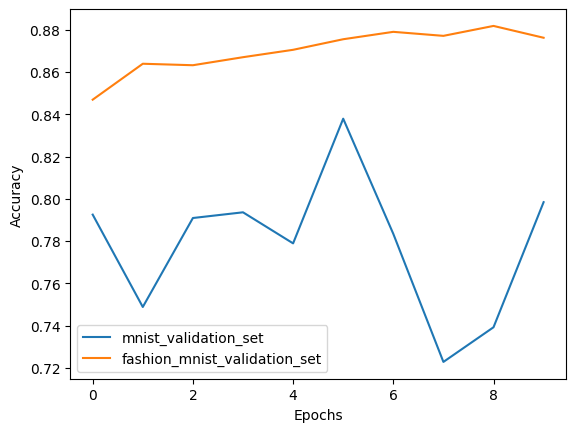

In [74]:
# plot validation acc's after training on fashion MNIST task

# We can now observe the impact of catastrophic forgetting has been greatly reduced

plot_validation_accs(si_mnist_val_accs_retrain,si_fashion_mnist_val_accs)

In [38]:
## Appendix: some preliminary code to save and restore using SI trainer (still kind of messy)


# save the trained model
new_model_v3 = new_model_v3.cpu()
torch.save(new_model_v3, "saved_models/adam_128bs_1e3_si_trainer_cnn_98acc.pth")
new_model_v3.cuda()

# save importance weights and snapshot of previous weights to make restoring possible for other trials
import pickle

snapshot_file = open('mnist_si_snapshot_prev_weights_cnn.pk', 'wb')
importance_params_file = open('mnist_si_prev_task_to_final_importance_params_cnn.pk', 'wb')
pickle.dump(trainer.snapshot_of_prev_task_weights, snapshot_file)
pickle.dump(trainer.prev_tasks_to_final_importance_params, importance_params_file)

importance_params_file.close()
snapshot_file.close()


# load back

snapshot_file = open('mnist_si_snapshot_prev_weights_cnn.pk', 'rb')
importance_params_file = open('mnist_si_prev_task_to_final_importance_params_cnn.pk', 'rb')

snapshot_prev_weights_restored = pickle.load(snapshot_file)
importance_params_restored = pickle.load(importance_params_file)

snapshot_file.close()
importance_params_file.close()


# restore model

# Basically, we can restore the model from a checkpoint and then train on fashion-MNIST but use SI
restored_model = torch.load("saved_models/adam_128bs_5e3_lr_si_trainer_889acc_before_si_cnn.pth")
restored_model.cuda()


# need to create an optimizer with the params of a new model cause we restored it
new_optimizer = optim.Adam(params=restored_model.parameters(), lr=5e-3)

# 
new_trainer = SITrainer(restored_model, new_optimizer, initial_task = 'mnist_task', lambda_weight = 0.15, debug=should_debug)
new_trainer.finish_task() # I think this causes issues because we aren't restoring the prev weights stuff

# === better way to restore the importance map ======

snapshot_file = open('mnist_si_snapshot_prev_weights_cnn.pk', 'rb')
importance_params_file = open('mnist_si_prev_task_to_final_importance_params_cnn.pk', 'rb')

snapshot_prev_weights_restored = pickle.load(snapshot_file)
importance_params_restored = pickle.load(importance_params_file)

snapshot_file.close()
importance_params_file.close()

new_trainer.snapshot_of_prev_task_weights = snapshot_prev_weights_restored
new_trainer.prev_tasks_to_final_importance_params = importance_params_restored

assert torch.sum(new_trainer.prev_tasks_to_final_importance_params['mnist_task']['fc2.weight']) > 1e-3